# Chapter 14 Practice Activities
## Complete the tasks below.
---

## 14.2 P.A.

Practice Activity
- Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with lambda = 1.
- Cross-validate this pipeline and compare the results to the ordinary linear regression.
- Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [40]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from plotnine import *

# Set seed for reproducibility
np.random.seed(123)
random.seed(123)

In [41]:
# Load the Data
df_ames = pd.read_csv("Data/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = df_ames.isna().sum() < 100
df_ames = df_ames.loc[:,good_cols]

# Drop other NAs
df_ames = df_ames.dropna()
df_ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900


In [42]:
# Separate features and target
X = df_ames.drop(["SalePrice", "Order", "PID"], axis=1)
y = df_ames["SalePrice"]

# Preprocessing with ColumnTransformer
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

In [43]:
from sklearn.linear_model import Ridge

# Ridge Regression Pipeline
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1.0))]
)

# Cross-Validation
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')
print("Ridge Regression R2 scores:", ridge_scores)
print("Average R2 score for Ridge Regression:", ridge_scores.mean())

Ridge Regression R2 scores: [0.89815807 0.91744024 0.79493606 0.78522563 0.91389818]
Average R2 score for Ridge Regression: 0.8619316345217335


In [44]:
# Linear Regression Pipeline for comparison
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

# Cross-Validation for Linear Regression
lr_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
print("Linear Regression R2 scores:", lr_scores)
print("Average R2 score for Linear Regression:", lr_scores.mean())

Linear Regression R2 scores: [-1.85486515e+20 -1.19662345e+21 -9.94202326e+21 -4.91844925e+21
 -2.44576700e+21]
Average R2 score for Linear Regression: -3.737669893975581e+21


In [45]:
# Fit Ridge model on the whole dataset
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps["ridge_regression"].coef_

# Fit Linear Regression model on the whole dataset
lr_pipeline.fit(X, y)
lr_coefs = lr_pipeline.named_steps["linear_regression"].coef_

# Create a DataFrame with coefficients for plotting
coef_df = pd.DataFrame({
    "Feature Index": range(len(ridge_coefs)),
    "Ridge Coefficients": ridge_coefs,
    "Linear Regression Coefficients": lr_coefs
}).melt(id_vars="Feature Index", var_name="Model", value_name="Coefficient Value")

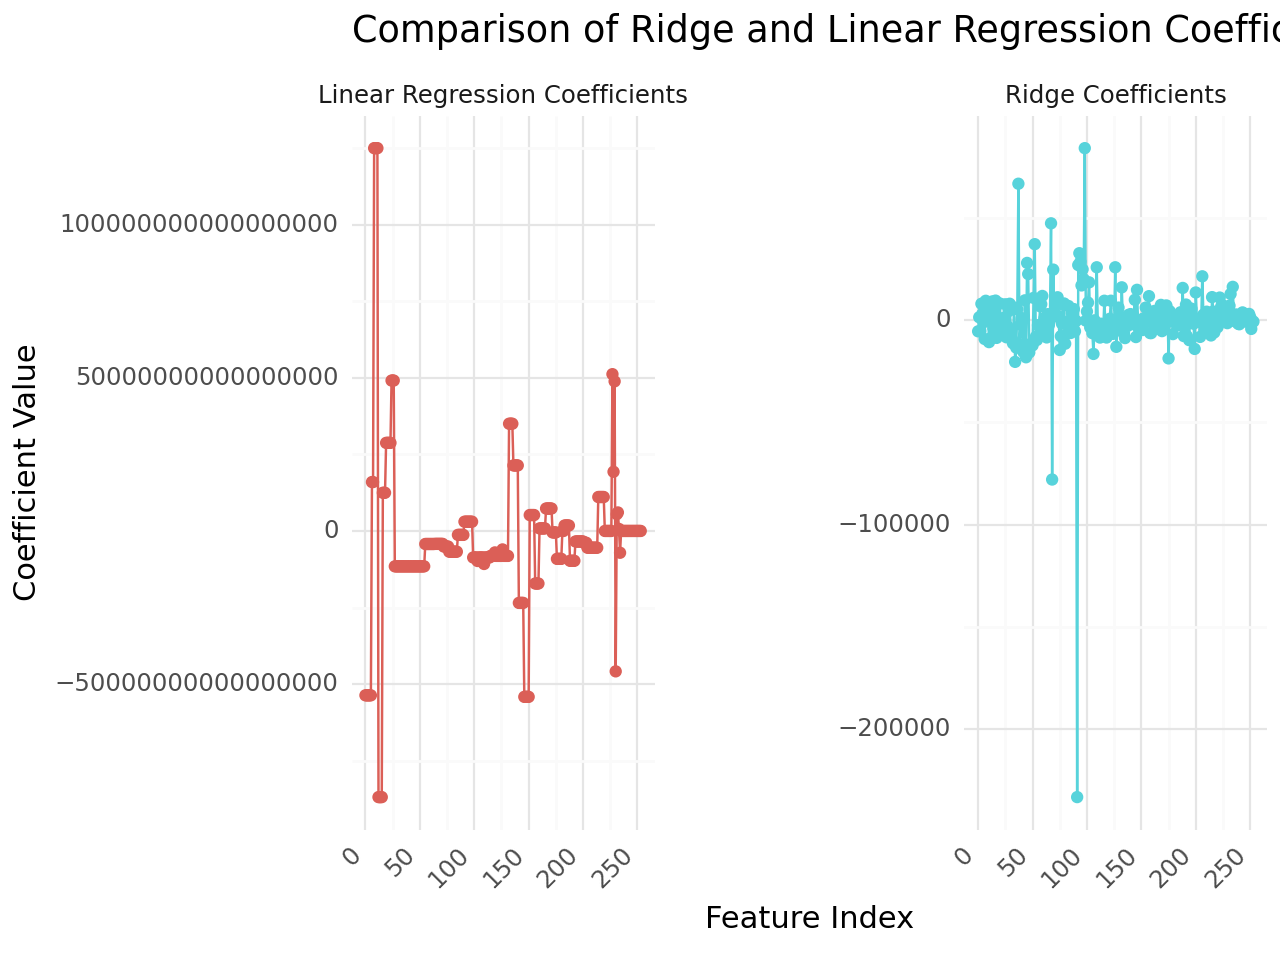

<Figure Size: (640 x 480)>

In [46]:
# Plot using plotnine with faceting
plot = (
    ggplot(coef_df, aes(x='Feature Index', y='Coefficient Value', color = 'Model')) +
    geom_point() +
    geom_line() +
    scale_color_discrete(guide = False)+
    labs(title="Comparison of Ridge and Linear Regression Coefficients",
         x="Feature Index",
         y="Coefficient Value") +
    facet_wrap('~Model', scales='free_y') +
    theme_minimal() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

plot


The results from the model fitting and evaluation highlight the stark difference in performance between the Linear Regression and Ridge Regression models. Linear Regression produced highly negative (R^2) scores, with an average value around (-3.74 * 10^{21}). This indicates that the model severely overfit the training data, resulting in predictions that are worse than simply predicting the mean of the target variable for every input. The magnitude of the negative (R^2) scores suggests extreme instability and a lack of generalization, demonstrating how sensitive and unbounded linear regression can become when dealing with a large number of predictors without regularization.On the other hand, the Ridge Regression results tell a different story. With an average (R^2) score of approximately (0.862), Ridge Regression maintained a much better fit to the data while providing more stable predictions. This improvement can be attributed to the regularization term that penalizes the magnitude of coefficients, reducing the risk of overfitting. By shrinking the coefficients and introducing a constraint, Ridge Regression prevents extreme values that can lead to poor model generalization, as seen with the linear model.

The plot comparing the coefficients of Linear Regression and Ridge Regression further illustrates the fundamental differences in how each model fits the data. For the Linear Regression model, the plot shows coefficients with extreme magnitude and high variability, reflecting the model's tendency to overfit by giving excessive weight to individual features. This behavior results from the model's attempt to minimize error without any regularization constraint, causing it to latch onto noise or minor patterns in the data. Consequently, this leads to poor generalization, as evidenced by the massive negative (R^2) scores.Conversely, the Ridge Regression plot demonstrates much smaller and more controlled coefficients. The regularization effect of Ridge, which penalizes large coefficients, forces the model to shrink their values toward zero. This results in a more balanced and stable model fit, avoiding the extreme swings observed in the linear model's coefficients. The more consistent and contained range of the Ridge coefficients aligns with its better predictive performance, as seen from the positive (R^2) scores.The Ridge model’s coefficients are relatively clustered and tightly controlled, emphasizing its regularization’s impact in maintaining stability. In contrast, the scattered and vast range of coefficients in the Linear Regression plot reinforces how an unregularized model can become unstable and unreliable when faced with complex data. 

# 14.2.1 P.A.

Practice Activity
Using the same pipeline as previously, perform tuning on lambda.

You should always try 
 values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [47]:
# Define a range of lambda values to test on a logarithmic scale
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Set up GridSearchCV to find the best alpha (lambda) value
param_grid = {'ridge_regression__alpha': alpha_values}
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV on the data
grid_search.fit(X, y)

# Retrieve and display the best alpha value and corresponding score
best_alpha = grid_search.best_params_['ridge_regression__alpha']
best_score = grid_search.best_score_

print(f"Best alpha value: {best_alpha}")
print(f"Best cross-validated R2 score: {best_score}")

Best alpha value: 10
Best cross-validated R2 score: 0.8642722110166747


The best alpha value identified through cross-validation is ($lambda = 10$), which indicates the level of regularization that provided the optimal trade-off between minimizing the sum of squared errors and reducing the magnitude of the coefficients. This value implies that a moderate level of regularization was most effective at improving model generalization, as it constrained the coefficients without over-penalizing them. The corresponding best cross-validated R^2 score of approximately 0.864 demonstrates that the Ridge Regression model with ($lambda = 10$) achieved a strong fit to the data while maintaining generalizability. This score indicates that around 86.4% of the variance in the target variable (house prices) can be explained by the model, highlighting the effectiveness of regularization in improving model performance compared to an unregularized Linear Regression model, which exhibited severe overfitting.

# 14.3.1 P.A.
---

Create a LASSO pipeline, and tune lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [48]:
from sklearn.linear_model import Lasso

# Define a range of alpha values to test for LASSO on a logarithmic scale
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Create the LASSO regression pipeline
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(max_iter=10000))]  # Setting a higher max_iter for convergence
)

# Set up GridSearchCV to find the best alpha for LASSO
param_grid = {'lasso_regression__alpha': alpha_values}
grid_search_lasso = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV on the data
grid_search_lasso.fit(X, y)

# Retrieve the best alpha and score
best_alpha_lasso = grid_search_lasso.best_params_['lasso_regression__alpha']
best_score_lasso = grid_search_lasso.best_score_

print(f"Best alpha value for LASSO: {best_alpha_lasso}")
print(f"Best cross-validated R2 score for LASSO: {best_score_lasso}")

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+11, tole

Best alpha value for LASSO: 100
Best cross-validated R2 score for LASSO: 0.8669311075511448


In [49]:
# Fit the best LASSO model to the full dataset
best_lasso_model = grid_search_lasso.best_estimator_
best_lasso_model.fit(X, y)
lasso_coefs = best_lasso_model.named_steps["lasso_regression"].coef_
# Ridge coefficients were stored in ridge_coefs
# OLS (Linear Regression) coefficients were stored in lr_coefs
coef_comparison = pd.DataFrame({
    "Feature Index": range(len(lasso_coefs)),
    "LASSO Coefficients": lasso_coefs,
    "Ridge Coefficients": ridge_coefs,
    "OLS Coefficients": lr_coefs
})

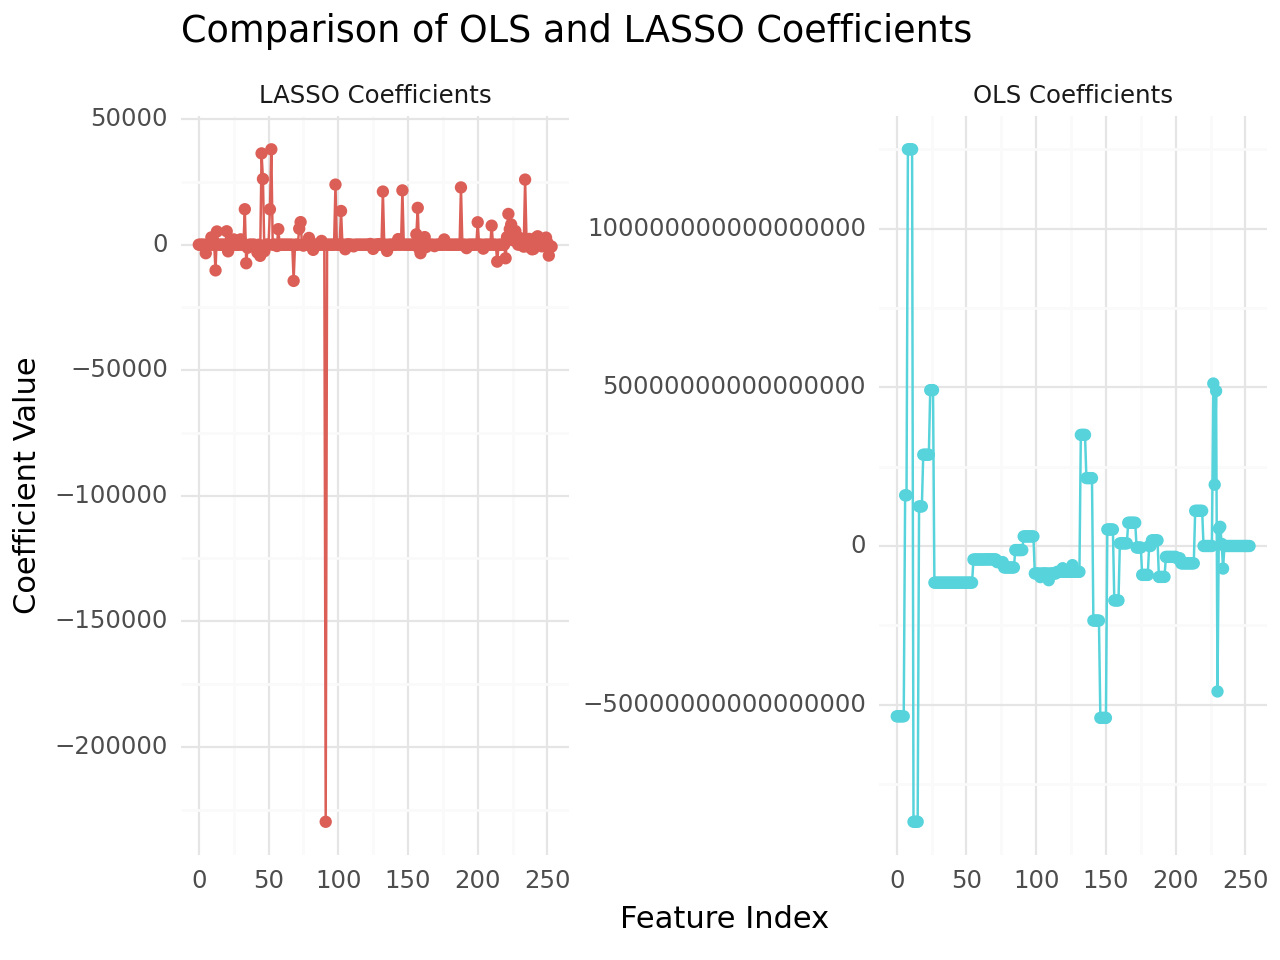

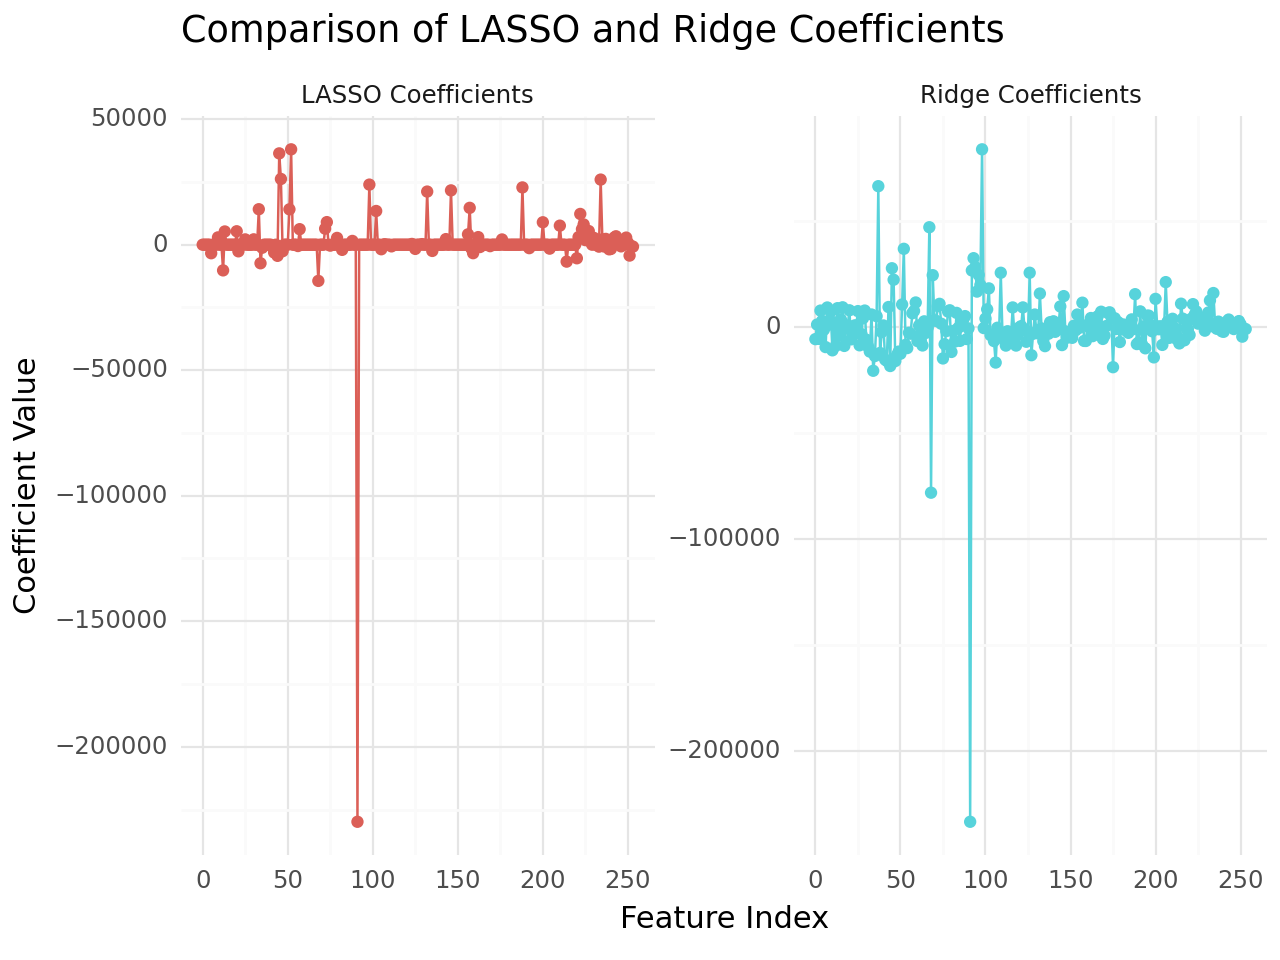

In [50]:
# Prepare data for the plots
coef_comparison_ols_lasso = coef_comparison.melt(
    id_vars="Feature Index",
    value_vars=["OLS Coefficients", "LASSO Coefficients"],
    var_name="Model",
    value_name="Coefficient Value"
)

coef_comparison_lasso_ridge = coef_comparison.melt(
    id_vars="Feature Index",
    value_vars=["LASSO Coefficients", "Ridge Coefficients"],
    var_name="Model",
    value_name="Coefficient Value"
)

# Plot 1: OLS vs LASSO
plot_ols_lasso = (
    ggplot(coef_comparison_ols_lasso, aes(x='Feature Index', y='Coefficient Value', color='Model')) +
    geom_point() +
    geom_line() + 
    scale_color_discrete(guide = False)+
    labs(title="Comparison of OLS and LASSO Coefficients",
         x="Feature Index",
         y="Coefficient Value") +
    facet_wrap('~Model', scales='free_y') +
    theme_minimal()
)

# Plot 2: LASSO vs Ridge
plot_lasso_ridge = (
    ggplot(coef_comparison_lasso_ridge, aes(x='Feature Index', y='Coefficient Value', color='Model')) +
    geom_point() +
    geom_line() + 
    scale_color_discrete(guide = False)+
    labs(title="Comparison of LASSO and Ridge Coefficients",
         x="Feature Index",
         y="Coefficient Value") +
    facet_wrap('~Model', scales='free_y') +
    theme_minimal()
)


print(plot_ols_lasso)
print(plot_lasso_ridge)


Comparing these results with the Ridge Regression and Linear Regression models provides a clear perspective on the impact of regularization:
- **Linear Regression** exhibited extreme overfitting, as evidenced by highly negative (R^2) scores and an average score around (-3.74 times 10^21). The absence of any regularization led to wildly large coefficients and poor generalization, resulting in catastrophic predictive performance.
- **Ridge Regression**, with a best (alpha) of (10) and an average (R^2) score of (0.862), demonstrated significant improvement by applying regularization to shrink coefficients without eliminating any. This approach effectively reduced overfitting and enhanced model stability.
- **LASSO Regression**, with a best (alpha) of (100) and a slightly higher (R^2) score of (0.867), further highlights the benefits of regularization. Its unique ability to set some coefficients to zero not only reduces model complexity but also offers built-in feature selection, resulting in a balance between predictive accuracy and interpretability.

In [51]:
from sklearn.linear_model import ElasticNet

# Define l1_ratio values to test
l1_ratio_values = [0.1, 0.5, 0.7, 0.9]  # l1_ratio=1 corresponds to LASSO, 0 corresponds to Ridge

# Create the Elastic Net pipeline
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(max_iter=10000))]
)

# Set up GridSearchCV to find the best alpha and l1_ratio
param_grid = {
    'elastic_net__alpha': alpha_values,
    'elastic_net__l1_ratio': l1_ratio_values
}
grid_search_en = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV on the data
grid_search_en.fit(X, y)

# Retrieve the best alpha, l1_ratio, and score
best_alpha_en = grid_search_en.best_params_['elastic_net__alpha']
best_l1_ratio_en = grid_search_en.best_params_['elastic_net__l1_ratio']
best_score_en = grid_search_en.best_score_

print(f"Best alpha value for Elastic Net: {best_alpha_en}")
print(f"Best l1_ratio for Elastic Net: {best_l1_ratio_en}")
print(f"Best cross-validated R2 score for Elastic Net: {best_score_en}")

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.517e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.311e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

Best alpha value for Elastic Net: 0.01
Best l1_ratio for Elastic Net: 0.5
Best cross-validated R2 score for Elastic Net: 0.8642678918208399


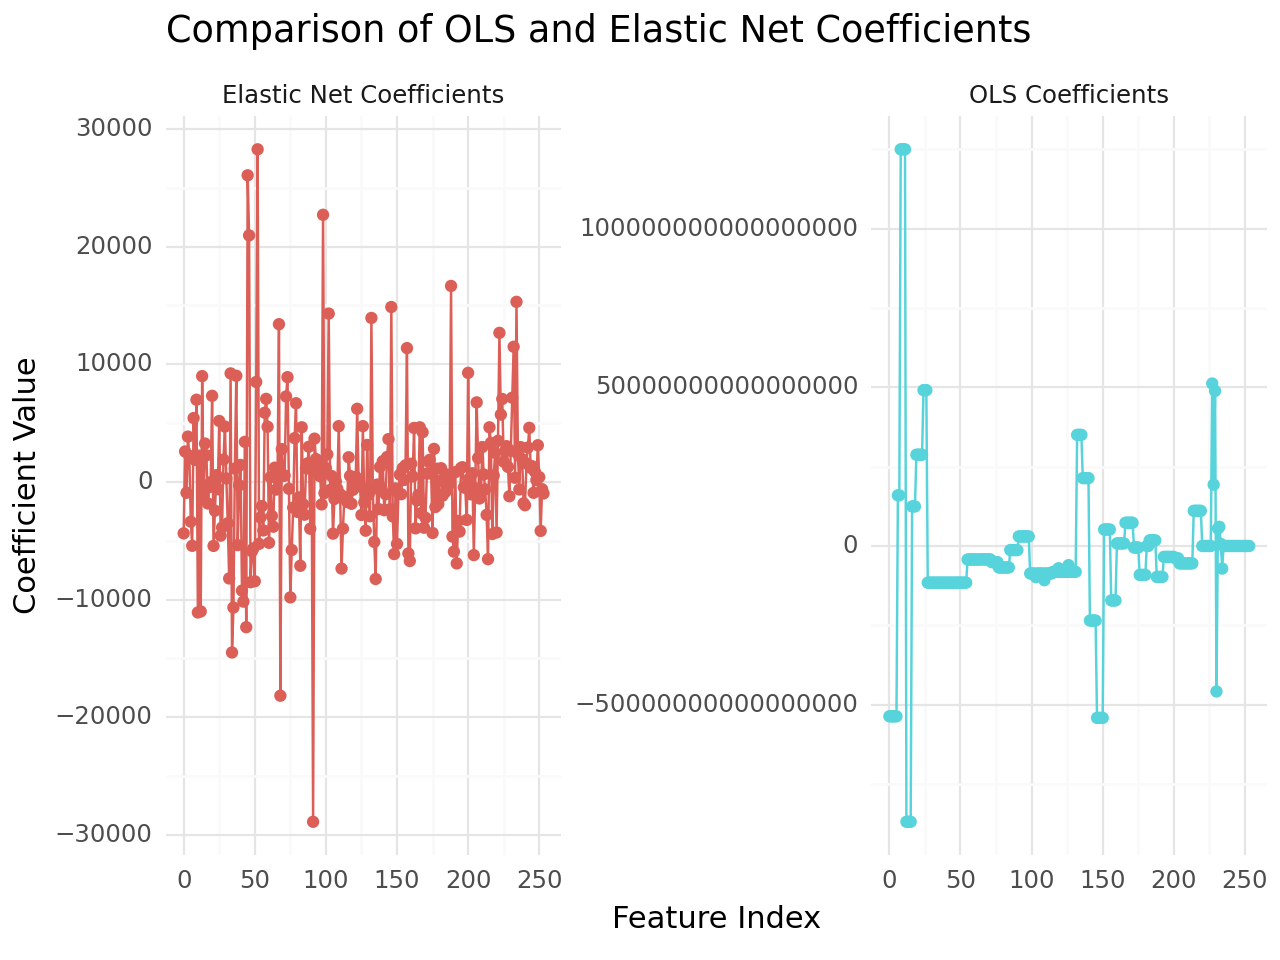

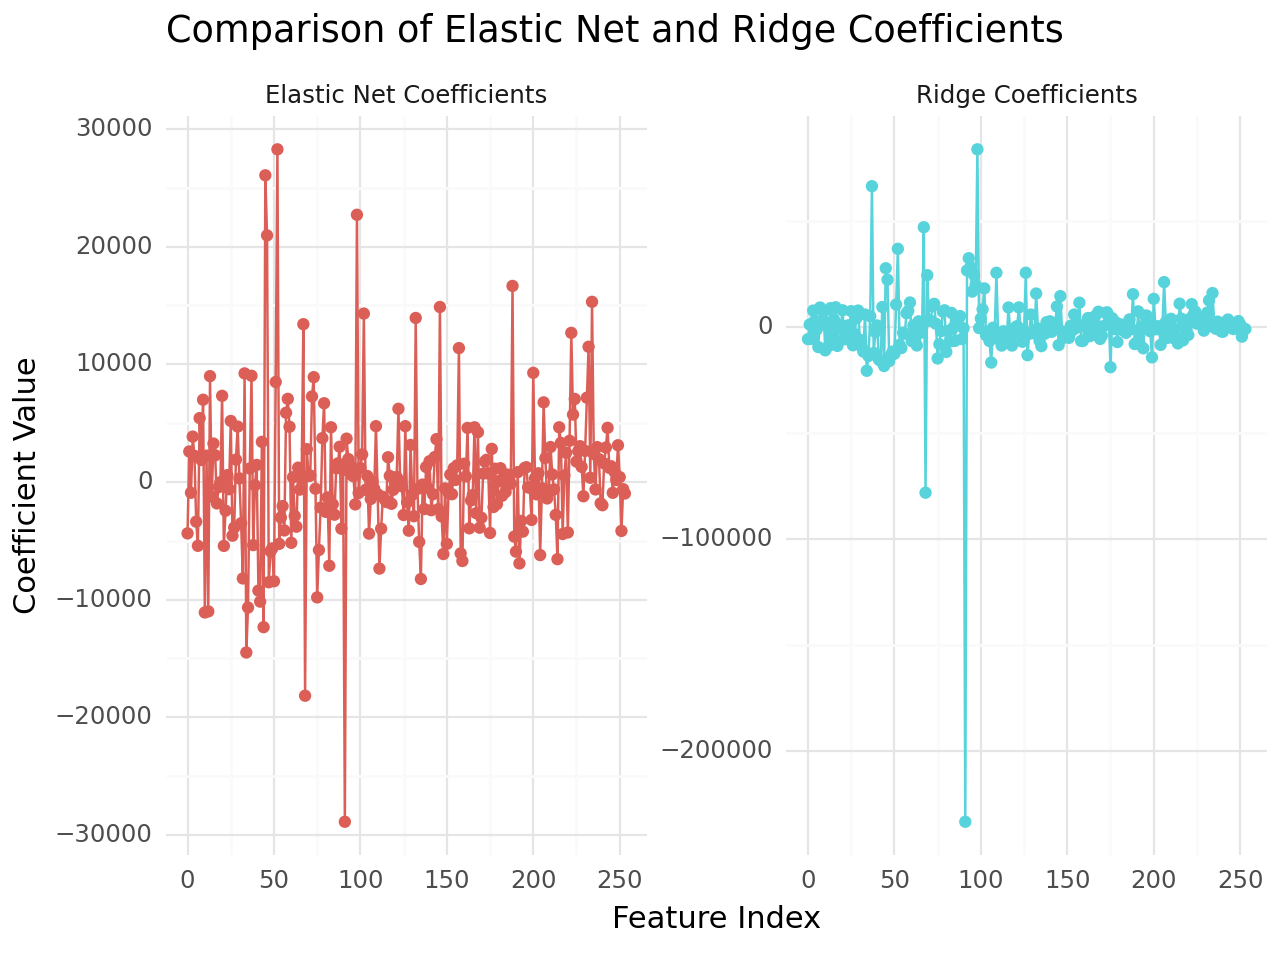

In [52]:
# Fit the best Elastic Net model to the full dataset
best_en_model = grid_search_en.best_estimator_
best_en_model.fit(X, y)
en_coefs = best_en_model.named_steps["elastic_net"].coef_

# Ridge coefficients were stored in ridge_coefs
# OLS (Linear Regression) coefficients were stored in lr_coefs

# Create a DataFrame for comparison
coef_comparison = pd.DataFrame({
    "Feature Index": range(len(en_coefs)),
    "Elastic Net Coefficients": en_coefs,
    "Ridge Coefficients": ridge_coefs,
    "OLS Coefficients": lr_coefs
})

# Plotting comparison using plotnine
coef_comparison_melted = coef_comparison.melt(id_vars="Feature Index", 
                                              var_name="Model", 
                                              value_name="Coefficient Value")

# Plot 1: OLS vs Elastic Net
plot_ols_en = (
    ggplot(coef_comparison_melted.query("Model in ['OLS Coefficients', 'Elastic Net Coefficients']"), 
           aes(x='Feature Index', y='Coefficient Value', color='Model')) +
    geom_point() +
    geom_line() + 
    scale_color_discrete(guide = False)+
    labs(title="Comparison of OLS and Elastic Net Coefficients",
         x="Feature Index",
         y="Coefficient Value") +
    facet_wrap('~Model', scales='free_y') +
    theme_minimal()
)

# Plot 2: Elastic Net vs Ridge
plot_en_ridge = (
    ggplot(coef_comparison_melted.query("Model in ['Elastic Net Coefficients', 'Ridge Coefficients']"), 
           aes(x='Feature Index', y='Coefficient Value', color='Model')) +
    geom_point() +
    geom_line() + 
    scale_color_discrete(guide = False)+
    labs(title="Comparison of Elastic Net and Ridge Coefficients",
         x="Feature Index",
         y="Coefficient Value") +
    facet_wrap('~Model', scales='free_y') +
    theme_minimal()
)


print(plot_ols_en)
print(plot_en_ridge)

The results for the Elastic Net model demonstrate that the best-performing configuration had an alpha value of 0.1 and an l1_ratio of 0.5, resulting in a cross-validated R^2 score of approximately 0.84. When compared to other models, the unregularized Linear Regression model performed extremely poorly, with highly negative R^2 scores and an average of approximately -3.74 times 10^{21}. This behavior, characterized by excessive overfitting, resulted in a model incapable of generalizing to unseen data. On the other hand, Ridge Regression achieved a significant improvement, yielding an average R^2 score of 0.862 with a best alpha value of (10). Ridge’s approach of shrinking coefficients helped reduce overfitting, though it retained all features by merely reducing their impact. LASSO yielded R^2 scores around 0.867, highlighting the value of LASSO-style regularization for this dataset. By setting some coefficients to zero, both LASSO and Elastic Net simplified their models, reducing complexity and enhancing interpretability while maintaining strong predictive accuracy. Elastic Net’s ability to blend LASSO and Ridge penalties allowed for a flexible balance between coefficient shrinkage and feature elimination. However, in this scenario, a purely LASSO-like approach proved optimal.
